Epoch 1/100
Epoch 1 | Loss: 21.584545135498047 | Training Accuracy: 0.08984375
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 11 | Loss: 3.4484381675720215 | Training Accuracy: 0.234375
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 21 | Loss: 2.3658957481384277 | Training Accuracy: 0.5625
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 31 | Loss: 2.272177219390869 | Training Accuracy: 0.5703125
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 41 | Loss: 2.132418394088745 | Training Accuracy: 0.671875
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 51 | Loss: 2

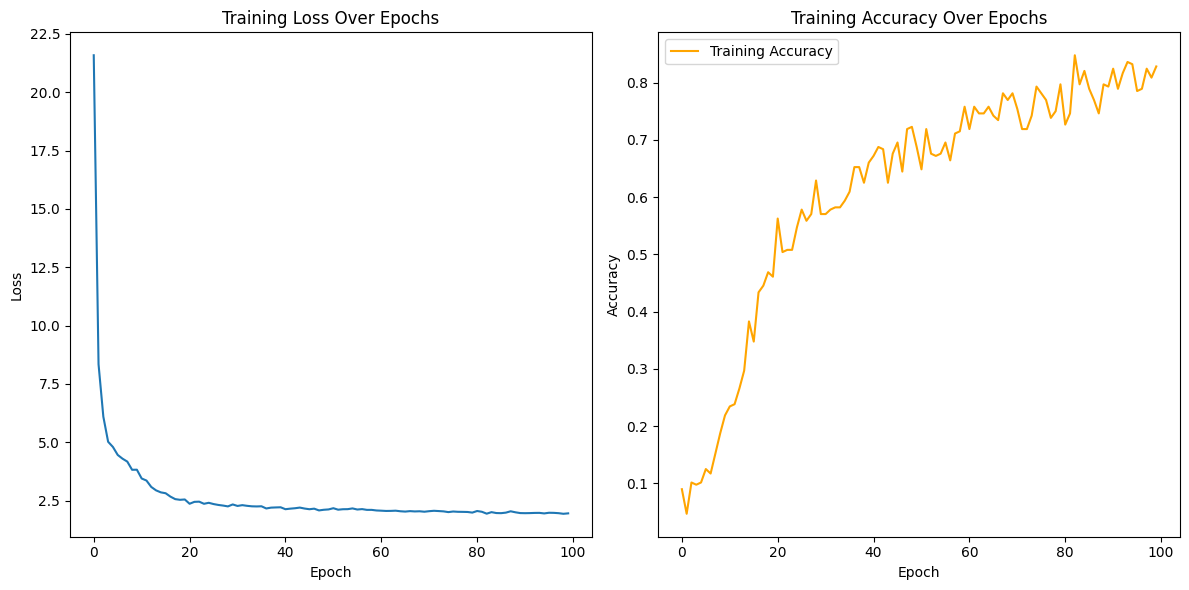

Test Accuracy: 66.94%


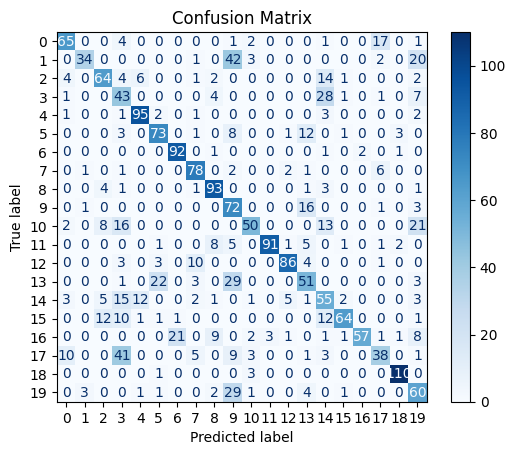

In [ ]:
import torch
import snntorch
import tonic
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from tonic import datasets, transforms
from collections import namedtuple
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter




device = torch.device("mps" if torch.cuda.is_available() else "cpu")


SAMPLE_T = 128  # Time steps per sample
SHD_TIMESTEP = 1e-6  # Time step of SHD dataset
SHD_CHANNELS = 700  # Number of input channels in the SHD dataset
NET_CHANNELS = 128  # Number of input channels in the network
NET_DT = 1 / SAMPLE_T  # Time step for network
BATCH_SIZE = 256  # Batch size
NUM_EPOCHS = 100  # Number of training epochs
NUM_HIDDEN = 64  # Number of hidden units in the network

# Set the input and output shapes
OBS_SHAPE = (NET_CHANNELS,)
ACT_SHAPE = (20,)



from datetime import datetime

# Set up TensorBoard w
run_name = f"SNN_3_lif_hidden_{NUM_HIDDEN}_epochs_{NUM_EPOCHS}"
writer = SummaryWriter(log_dir=f"runs/{run_name}")




class _SHD2Raster():
    """ 
    Tool for rastering SHD samples into frames. Packs bits along the temporal axis for memory efficiency. This means
        that the used will have to apply jnp.unpackbits(events, axis=<time axis>) prior to feeding the data to the network.
    """

    def __init__(self, encoding_dim, sample_T = 100):
        self.encoding_dim = encoding_dim
        self.sample_T = sample_T
        
    def __call__(self, events):
        # tensor has dimensions (time_steps, encoding_dim)
        tensor = np.zeros((events["t"].max()+1, self.encoding_dim), dtype=int)
        np.add.at(tensor, (events["t"], events["x"]), 1)
        #return tensor[:self.sample_T,:]
        tensor = tensor[:self.sample_T,:]
        tensor = np.minimum(tensor, 1)
        #tensor = np.packbits(tensor, axis=0) pytorch does not have an unpack feature.
        return tensor
    
    
# Data transformations
transform = transforms.Compose([
    transforms.Downsample(time_factor=SHD_TIMESTEP / NET_DT, spatial_factor=NET_CHANNELS / SHD_CHANNELS),
    _SHD2Raster(NET_CHANNELS, sample_T=SAMPLE_T)
])


train_dataset = datasets.SHD("../data", train=True, transform=transform)
test_dataset = datasets.SHD("../data", train=False, transform=transform)

def shuffle(dataset):
    """Shuffles the dataset and batches it for training."""
    x, y = dataset
    cutoff = y.shape[0] % BATCH_SIZE
    indices = torch.randperm(y.shape[0])[:-cutoff]
    x, y = x[indices], y[indices]
    x = torch.reshape(x, (-1, BATCH_SIZE) + x.shape[1:])
    y = torch.reshape(y, (-1, BATCH_SIZE))  # Global batch size
    return namedtuple("State", "obs labels")(x, y)

train_dl = iter(DataLoader(train_dataset, batch_size=len(train_dataset),
                           collate_fn=tonic.collation.PadTensors(batch_first=True), drop_last=True, shuffle=False))
x_train, y_train = next(train_dl)
x_train, y_train = x_train.to(torch.uint8), y_train.to(torch.uint8)
x_train, y_train = x_train.to(device), y_train.to(device)

test_dl = iter(DataLoader(test_dataset, batch_size=len(test_dataset),
                          collate_fn=tonic.collation.PadTensors(batch_first=True), drop_last=True, shuffle=False))
x_test, y_test = next(test_dl)
x_test, y_test = x_test.to(torch.uint8), y_test.to(torch.uint8)
x_test, y_test = x_test.to(device), y_test.to(device)
x_test, y_test = shuffle((x_test, y_test))


class SNNModel(torch.nn.Module):
    """
    A simple Spiking Neural Network (SNN) with Leaky Integrate-and-Fire (LIF) neurons.
    """
    def __init__(self, num_hidden=NUM_HIDDEN, output_size=20):
        super(SNNModel, self).__init__()
        
       
        self.fc1 = torch.nn.Linear(NET_CHANNELS, num_hidden)
        self.lif1 = snntorch.Leaky(beta=torch.ones(num_hidden) * 0.5, learn_beta=True)

        self.fc2 = torch.nn.Linear(num_hidden, num_hidden)
        self.lif2 = snntorch.Leaky(beta=torch.ones(num_hidden) * 0.5, learn_beta=True)

        self.fc3 = torch.nn.Linear(num_hidden, output_size)
        self.lif3 = snntorch.Leaky(beta=torch.ones(output_size) * 0.5, learn_beta=True, reset_mechanism="none")

    def forward(self, x):
        """
        Forward pass through the network.
        :param x: Input tensor of shape (batch_size, time_steps, channels)
        :return: Output spikes over time (time_steps, batch_size, output_size)
        """
        x = x.float()  # ensures float type for network
        x = x.permute(1, 0, 2)  # (time_steps, batch_size, channels)

        # init membrane potentials
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spikes = []

        for step in x:
            cur1 = self.fc1(step)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spikes.append(mem3)

        return torch.stack(spikes, axis=0).permute(1, 0, 2)  # (batch_size, time_steps, output_size)


model = SNNModel(num_hidden=NUM_HIDDEN).to(device)


loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


def accuracy(predictions, targets):
    """Calculates the accuracy of the model's predictions."""
    return (torch.argmax(predictions, axis=-1) == targets).sum().item() / len(targets)


# train loop and logging
loss_history = []
train_accuracies = []
for epoch in range(NUM_EPOCHS):
    model.train()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    # Shuffle the training data at the start of each epoch
    train_batch = shuffle((x_train, y_train))
    train_data, targets = train_batch

    # Mini-batch training
    for data, target in zip(train_data, targets):
        # Forward pass
        optimizer.zero_grad()
        out_V = model(data)

        # Calculate loss
        loss_val = loss_fn(torch.sum(out_V, axis=-2), target)

        # backprop and optmization
        loss_val.backward()
        optimizer.step()

    # Log training loss and accuracy to TensorBoard
    loss_history.append(loss_val.item())
    train_acc = accuracy(torch.sum(out_V, axis=-2), target)
    train_accuracies.append(train_acc)
    writer.add_scalar("Loss/train", loss_val.item(), epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)

    # Periodic logging and visualization
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss_val.item()} | Training Accuracy: {train_acc}")

# Visualize Loss and Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation with Metrics
def evaluate(model, x_test, y_test):
    """Evaluates the model's accuracy on the test set and returns the confusion matrix."""
    model.eval()
    test_acc = 0
    batch_acc = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for test_data, test_targets in zip(x_test, y_test):
            out_V = model(test_data)
            batch_acc.append(accuracy(torch.sum(out_V, axis=-2), test_targets))
            all_preds.append(torch.argmax(torch.sum(out_V, axis=-2), axis=-1))
            all_targets.append(test_targets)

    test_acc = np.mean(batch_acc)
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # confusion matrix
    cm = confusion_matrix(all_targets.cpu(), all_preds.cpu())
    cm_display = ConfusionMatrixDisplay(cm, display_labels=[str(i) for i in range(20)])

    return test_acc, cm_display

# Test accuracy and confusion matrix
test_acc, cm_display = evaluate(model, x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot confusion matrix
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

writer.close()
